In [1]:
import pandas as pd
import numpy as np

#Loading the Dataset

In [2]:
train_invoice= pd.read_csv('/content/drive/MyDrive/PROJECT/E & G Fraud/invoice_train.csv',low_memory=False)
test_invoice= pd.read_csv('/content/drive/MyDrive/PROJECT/E & G Fraud/invoice_test.csv')
train_client= pd.read_csv('/content/drive/MyDrive/PROJECT/E & G Fraud/client_train.csv')
test_client=pd.read_csv('/content/drive/MyDrive/PROJECT/E & G Fraud/client_test.csv')

In [3]:
train_invoice.shape, test_invoice.shape ,train_client.shape ,test_client.shape

((4476749, 16), (1939730, 16), (135493, 6), (58069, 5))

Train Data

In [4]:
train_invoice.shape, train_client.shape

((4476749, 16), (135493, 6))

In [5]:
train_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC


In [6]:
train_client.head()

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0


In [7]:
print(train_invoice.columns)
print('\n')
print(train_client.columns)
print('\n')
print(train_invoice.dtypes)
print('\n')
print(train_client.dtypes)
print('\n')
print(train_invoice.isna().sum())
print('\n')
print(train_client.isna().sum())

Index(['client_id', 'invoice_date', 'tarif_type', 'counter_number',
       'counter_statue', 'counter_code', 'reading_remarque',
       'counter_coefficient', 'consommation_level_1', 'consommation_level_2',
       'consommation_level_3', 'consommation_level_4', 'old_index',
       'new_index', 'months_number', 'counter_type'],
      dtype='object')


Index(['disrict', 'client_id', 'client_catg', 'region', 'creation_date',
       'target'],
      dtype='object')


client_id               object
invoice_date            object
tarif_type               int64
counter_number           int64
counter_statue          object
counter_code             int64
reading_remarque         int64
counter_coefficient      int64
consommation_level_1     int64
consommation_level_2     int64
consommation_level_3     int64
consommation_level_4     int64
old_index                int64
new_index                int64
months_number            int64
counter_type            object
dtype: object


disrict            i

In [8]:
train_client['target'].unique()

array([0., 1.])

Number of Fraudless CLients:  127927  Or  94.4 % of the data
Number of Fraud Clients:  7566  Or  5.6 % of the data


<Axes: xlabel='target', ylabel='count'>

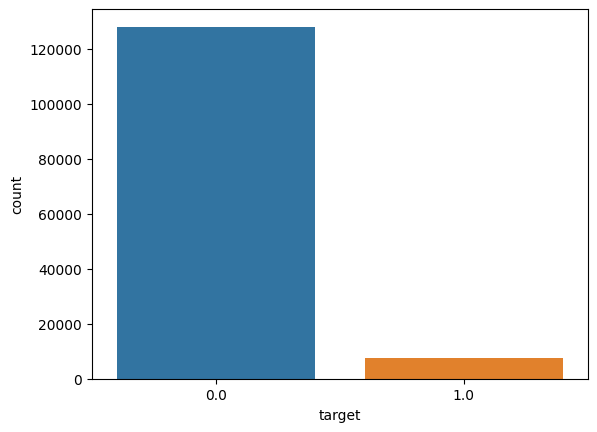

In [9]:
FL, F = train_client['target'].value_counts()
print('Number of Fraudless CLients: ', FL, ' Or ', round(FL/(FL+F)*100,1), '% of the data')
print('Number of Fraud Clients: ', F, ' Or ', round(F/(FL+F)*100,1), '% of the data')

import seaborn as sns

sns.countplot(x=train_client['target'],data=train_client)


The fraud class is much smaller than the fraudless class so the data is imbalanced.
Using unsupervised anomaly detection model for prediction.


#Train Data

In [ ]:
train_invoice['counter_statue'].unique()

array(['0', '1', '5', '4', '3', '2', '769', 'A', '618', '269375', '46',
       '420'], dtype=object)

In [10]:
def wrangle(df):

    #converting "invoice_date" to datetime and sorting data
    df["invoice_date"] = pd.to_datetime(df["invoice_date"])
    df.sort_values(['client_id', 'invoice_date'], ascending=[True, True], inplace=True)

    #map unique "counter_statue"
    dic = {0:0, 1:1, 2:2, 3:3, 4:4, 5:5, 46:6, 420:7, 618:8, 269375:9, '0':0, '1':1, '4':4, '5':5, 'A':-1}
    df['counter_statue'] = df['counter_statue'].map(dic)

    #map "counter_type"
    d={"ELEC":0,"GAZ":1}
    df['counter_type'] = df['counter_type'].map(d)

    #creating new column(index_change) using old_index and new_index values
    #index_change was normalized between -1 & 1
    df['index_change'] = df['new_index']-df['old_index']

    replica= df.copy()
    replica['index_change'] = replica['index_change'].abs()
    frac = replica.groupby(['client_id'])['index_change'].transform('max')
    frac.replace(0, 1e-40, inplace=True)
    df['index_change'] = df['index_change']//frac
    del replica

    #calculating difference in invoice_dates in days
    diff_dates = df['invoice_date'].diff(periods=1)
    diff_dates.iloc[0] = pd.Timedelta("0 days")

    diff_dates = (diff_dates//np.timedelta64(1, 'D')).astype(int)
    diff_dates.loc[diff_dates<0] = 0
    df['diff_dates'] = diff_dates

    return df

train = wrangle(train_invoice)

In [11]:
train

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,index_change,diff_dates
22,train_Client_0,2005-10-17,11,1335667,0.0,203,6,1,124,0,0,0,3685,3809,4,0,0.0,0
23,train_Client_0,2006-02-24,11,1335667,0.0,203,6,1,141,0,0,0,3809,3950,4,0,0.0,130
24,train_Client_0,2006-06-23,11,1335667,0.0,203,6,1,162,0,0,0,3950,4112,4,0,0.0,119
25,train_Client_0,2006-10-18,11,1335667,0.0,203,6,1,159,0,0,0,4112,4271,4,0,0.0,117
28,train_Client_0,2007-02-26,11,1335667,0.0,203,6,1,182,0,0,0,4271,4453,4,0,0.0,131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0.0,202,9,1,400,135,0,0,3197,3732,8,0,1.0,0
4476745,train_Client_99998,2005-12-19,10,1253571,0.0,202,6,1,200,6,0,0,3732,3938,4,0,0.0,122
4476748,train_Client_99999,1996-01-25,11,560948,0.0,203,6,1,516,0,0,0,12765,13281,4,0,0.0,0
4476747,train_Client_99999,1996-05-28,11,560948,0.0,203,6,1,603,0,0,0,13281,13884,4,0,1.0,124


In [12]:
print(train.dtypes)
print('\n')
print(train.isna().sum())

client_id                       object
invoice_date            datetime64[ns]
tarif_type                       int64
counter_number                   int64
counter_statue                 float64
counter_code                     int64
reading_remarque                 int64
counter_coefficient              int64
consommation_level_1             int64
consommation_level_2             int64
consommation_level_3             int64
consommation_level_4             int64
old_index                        int64
new_index                        int64
months_number                    int64
counter_type                     int64
index_change                   float64
diff_dates                       int64
dtype: object


client_id                 0
invoice_date              0
tarif_type                0
counter_number            0
counter_statue          324
counter_code              0
reading_remarque          0
counter_coefficient       0
consommation_level_1      0
consommation_level_2      0
co

The data is grouped by clients so using simple statictics to get single values is necessary.

1. The number of transactions may show if fraud clients have more or less transactions than fraudless
2. The mean value for each four levels of consumption is useful
3. The maximum values for the tarif_type and reading_remarks indicate unfavorable behaviour
4. The mean change in index values may show if index values have been tampered with
5.The median difference in transaction dates could indicated transaction behaviour

Along with these obtained values client catagory, district, and region are also useful indicators

In [13]:
aggs = {}

aggs['consommation_level_1'] = ['mean']

aggs['consommation_level_2'] = ['mean']

aggs['consommation_level_3'] = ['mean']

aggs['consommation_level_4'] = ['mean']

aggs['tarif_type'] = ['max']

aggs['reading_remarque'] = ['max']

aggs['index_change'] = ['mean']


aggs['diff_dates'] = ['median']


agg_trans = train.groupby(['client_id']).agg(aggs)
agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
agg_trans.reset_index(inplace=True)

df = (train.groupby('client_id').size().reset_index(name='transactions_count'))

agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

In [14]:
agg_trans.head()

,client_id,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type_max,reading_remarque_max,index_change_mean,diff_dates_median
0,train_Client_0,35,352.400000,10.571429,0.000000,0.000000,11,9,0.028571,120.0
1,train_Client_1,37,557.540541,0.000000,0.000000,0.000000,11,9,0.027027,121.0
2,train_Client_10,18,798.611111,37.888889,0.000000,0.000000,11,9,0.055556,135.5
3,train_Client_100,20,1.200000,0.000000,0.000000,0.000000,11,9,0.050000,120.5
4,train_Client_1000,14,663.714286,104.857143,117.357143,36.714286,11,9,0.071429,135.5


In [15]:
X = pd.merge(train_client,agg_trans, on='client_id', how='left')

In [16]:
X

,disrict,client_id,client_catg,region,creation_date,target,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type_max,reading_remarque_max,index_change_mean,diff_dates_median
0,60,train_Client_0,11,101,31/12/1994,0.0,35,352.400000,10.571429,0.000000,0.000000,11,9,0.028571,120.0
1,69,train_Client_1,11,107,29/05/2002,0.0,37,557.540541,0.000000,0.000000,0.000000,11,9,0.027027,121.0
2,62,train_Client_10,11,301,13/03/1986,0.0,18,798.611111,37.888889,0.000000,0.000000,11,9,0.055556,135.5
3,69,train_Client_100,11,105,11/07/1996,0.0,20,1.200000,0.000000,0.000000,0.000000,11,9,0.050000,120.5
4,62,train_Client_1000,11,303,14/10/2014,0.0,14,663.714286,104.857143,117.357143,36.714286,11,9,0.071429,135.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.0,71,1.957746,0.000000,0.000000,0.000000,40,6,0.000000,113.0
135489,63,train_Client_99996,11,311,25/10/2012,0.0,41,185.853659,0.756098,0.000000,0.000000,40,9,0.024390,0.0
135490,63,train_Client_99997,11,311,22/11/2011,0.0,36,273.083333,0.000000,0.000000,0.000000,40,9,0.027778,17.0
135491,60,train_Client_99998,11,101,22/12/1993,0.0,2,300.000000,70.500000,0.000000,0.000000,10,9,0.500000,61.0


In [17]:
X.isnull().sum()

disrict                      0
client_id                    0
client_catg                  0
region                       0
creation_date                0
target                       0
transactions_count           0
consommation_level_1_mean    0
consommation_level_2_mean    0
consommation_level_3_mean    0
consommation_level_4_mean    0
tarif_type_max               0
reading_remarque_max         0
index_change_mean            0
diff_dates_median            0
dtype: int64

#Test data

In [18]:
test_invoice.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,test_Client_0,2018-03-16,11,651208,0,203,8,1,755,0,0,0,19145,19900,8,ELEC
1,test_Client_0,2014-03-21,11,651208,0,203,8,1,1067,0,0,0,13725,14792,8,ELEC
2,test_Client_0,2014-07-17,11,651208,0,203,8,1,0,0,0,0,14792,14792,4,ELEC
3,test_Client_0,2015-07-13,11,651208,0,203,9,1,410,0,0,0,16122,16532,4,ELEC
4,test_Client_0,2016-07-19,11,651208,0,203,9,1,412,0,0,0,17471,17883,4,ELEC


In [19]:
test_client.head()

,disrict,client_id,client_catg,region,creation_date
0,62,test_Client_0,11,307,28/05/2002
1,69,test_Client_1,11,103,06/08/2009
2,62,test_Client_10,11,310,07/04/2004
3,60,test_Client_100,11,101,08/10/1992
4,62,test_Client_1000,11,301,21/07/1977


In [20]:
test = wrangle(test_invoice)
test.head()

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type,index_change,diff_dates
27,test_Client_0,2005-12-16,11,651208,0,203,6,1,326,0,0,0,3057,3383,4,0,0.0,0
26,test_Client_0,2006-03-27,11,651208,0,203,6,1,275,0,0,0,3383,3658,2,0,0.0,101
25,test_Client_0,2006-07-21,11,651208,0,203,6,1,366,0,0,0,3658,4024,4,0,0.0,116
24,test_Client_0,2006-11-20,11,651208,0,203,6,1,428,0,0,0,4024,4452,4,0,0.0,122
23,test_Client_0,2007-03-23,11,651208,0,203,6,1,284,0,0,0,4452,4736,4,0,0.0,123


In [21]:
agg_trans = test.groupby(['client_id']).agg(aggs)
agg_trans.columns = ['_'.join(col).strip() for col in agg_trans.columns.values]
agg_trans.reset_index(inplace=True)

df = (test.groupby('client_id').size().reset_index(name='transactions_count'))

agg_trans = pd.merge(df, agg_trans, on='client_id', how='left')

In [22]:
Y = pd.merge(test_client,agg_trans, on='client_id', how='left')

In [23]:
Y

,disrict,client_id,client_catg,region,creation_date,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type_max,reading_remarque_max,index_change_mean,diff_dates_median
0,62,test_Client_0,11,307,28/05/2002,37,488.135135,3.243243,0.000000,0.000000,11,9,0.027027,122.0
1,69,test_Client_1,11,103,06/08/2009,22,1091.409091,843.136364,182.318182,586.318182,11,9,0.045455,124.5
2,62,test_Client_10,11,310,07/04/2004,74,554.040541,37.364865,15.743243,0.162162,40,9,0.013514,117.0
3,60,test_Client_100,11,101,08/10/1992,40,244.350000,0.000000,0.000000,0.000000,40,9,0.025000,0.0
4,62,test_Client_1000,11,301,21/07/1977,53,568.188679,145.056604,33.679245,0.000000,40,9,0.018868,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58064,63,test_Client_9995,11,399,17/03/2010,4,461.250000,0.000000,0.000000,0.000000,40,6,0.250000,0.0
58065,63,test_Client_9996,11,311,28/05/2011,46,181.565217,0.000000,0.000000,0.000000,40,9,0.021739,32.5
58066,60,test_Client_9997,11,101,04/03/1978,59,160.559322,11.932203,0.000000,0.000000,40,9,0.016949,27.0
58067,60,test_Client_9998,11,101,23/02/2018,1,800.000000,400.000000,727.000000,0.000000,11,9,1.000000,0.0


In [24]:
Y.isnull().sum()

disrict                      0
client_id                    0
client_catg                  0
region                       0
creation_date                0
transactions_count           0
consommation_level_1_mean    0
consommation_level_2_mean    0
consommation_level_3_mean    0
consommation_level_4_mean    0
tarif_type_max               0
reading_remarque_max         0
index_change_mean            0
diff_dates_median            0
dtype: int64

In [25]:
X.shape,Y.shape

((135493, 15), (58069, 14))

#Normalize / standardize the data

In [26]:
x = X.drop(['client_id','target','creation_date'],axis=1)
y = X['target']

In [27]:
x.shape,y.shape

((135493, 12), (135493,))

In [28]:
x.describe()

,disrict,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type_max,reading_remarque_max,index_change_mean,diff_dates_median
count,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000,135493.000000
mean,63.511222,11.512506,206.159809,33.040445,432.366021,115.334253,27.634241,73.097981,24.334785,8.674419,0.097119,98.275036
std,3.354400,4.423761,104.207044,26.092229,758.003977,747.416809,157.294518,814.216626,14.461639,1.689167,0.175741,341.559525
min,60.000000,11.000000,101.000000,1.000000,0.000000,0.000000,0.000000,0.000000,10.000000,6.000000,-1.000000,0.000000
25%,62.000000,11.000000,103.000000,10.000000,215.280702,0.000000,0.000000,0.000000,11.000000,9.000000,0.018182,0.000000
50%,62.000000,11.000000,107.000000,30.000000,355.640625,4.987179,0.000000,0.000000,11.000000,9.000000,0.031250,87.000000
75%,69.000000,11.000000,307.000000,50.000000,541.888889,63.636364,3.929825,0.000000,40.000000,9.000000,0.083333,121.000000
max,69.000000,51.000000,399.000000,439.000000,99920.000000,115683.000000,38526.857143,79179.777778,45.000000,413.000000,1.000000,14896.000000


In [29]:
from sklearn.preprocessing import StandardScaler

sc= StandardScaler()
sc.fit(x)
x_arr= sc.transform(x)
x_std= pd.DataFrame(x_arr, index= x.index, columns= x.columns)
x_std.describe()

,disrict,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type_max,reading_remarque_max,index_change_mean,diff_dates_median
count,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05,1.354930e+05
mean,-2.635699e-16,9.879939e-17,-4.617455e-17,5.134002e-17,1.778808e-16,-1.080291e-17,-1.371340e-17,1.054070e-17,-1.520797e-17,3.833983e-16,-7.394222e-17,-1.510309e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00,1.000004e+00
min,-1.046755e+00,-1.158535e-01,-1.009147e+00,-1.227973e+00,-5.704028e-01,-1.543111e-01,-1.756854e-01,-8.977740e-02,-9.912319e-01,-1.583282e+00,-6.242845e+00,-2.877255e-01
25%,-4.505209e-01,-1.158535e-01,-9.899541e-01,-8.830418e-01,-2.863918e-01,-1.543111e-01,-1.756854e-01,-8.977740e-02,-9.220832e-01,1.927474e-01,-4.491712e-01,-2.877255e-01
50%,-4.505209e-01,-1.158535e-01,-9.515688e-01,-1.165273e-01,-1.012207e-01,-1.476385e-01,-1.756854e-01,-8.977740e-02,-9.220832e-01,1.927474e-01,-3.748105e-01,-3.301058e-02
75%,1.636298e+00,-1.158535e-01,9.676943e-01,6.499873e-01,1.444890e-01,-6.916901e-02,-1.507014e-01,-8.977740e-02,1.083229e+00,1.927474e-01,-7.844509e-02,6.653320e-02
max,1.636298e+00,8.926261e+00,1.850555e+00,1.555870e+01,1.312500e+02,1.546234e+02,2.447597e+02,9.715716e+01,1.428973e+00,2.393648e+02,5.137585e+00,4.332416e+01


In [30]:
x_std.isna().sum()

disrict                      0
client_catg                  0
region                       0
transactions_count           0
consommation_level_1_mean    0
consommation_level_2_mean    0
consommation_level_3_mean    0
consommation_level_4_mean    0
tarif_type_max               0
reading_remarque_max         0
index_change_mean            0
diff_dates_median            0
dtype: int64

#Anomaly Detection

# Isolation Forest

In [31]:
from sklearn.ensemble import IsolationForest

anomaly_inputs = x_std.columns


In [32]:
model_IF= IsolationForest(contamination= 0.1, random_state=1823)
model_IF.fit(x_std[anomaly_inputs])
X['anomaly_scores']= model_IF.decision_function(x_std[anomaly_inputs])
X['anomaly'] = model_IF.predict(x_std[anomaly_inputs])
det= pd.DataFrame(X['anomaly'])
det['anomaly'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    121943
-1     13550
Name: anomaly, dtype: int64

#Parameter Tuning

In [33]:
model_IF= IsolationForest(contamination= 0.08, random_state=1823)
model_IF.fit(x_std[anomaly_inputs])
X['anomaly_scores']= model_IF.decision_function(x_std[anomaly_inputs])
X['anomaly'] = model_IF.predict(x_std[anomaly_inputs])
det= pd.DataFrame(X['anomaly'])
det['anomaly'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    124653
-1     10840
Name: anomaly, dtype: int64

In [34]:
model_IF= IsolationForest(contamination= 0.06, random_state=1823)
model_IF.fit(x_std[anomaly_inputs])
X['anomaly_scores']= model_IF.decision_function(x_std[anomaly_inputs])
X['anomaly'] = model_IF.predict(x_std[anomaly_inputs])
det= pd.DataFrame(X['anomaly'])
det['anomaly'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    127363
-1      8130
Name: anomaly, dtype: int64

In [35]:
model_IF= IsolationForest(contamination= 0.0558, random_state=1823)
model_IF.fit(x_std[anomaly_inputs])
X['anomaly_scores']= model_IF.decision_function(x_std[anomaly_inputs])
X['anomaly'] = model_IF.predict(x_std[anomaly_inputs])
det= pd.DataFrame(X['anomaly'])
det['anomaly'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    127932
-1      7561
Name: anomaly, dtype: int64

with this model the fraud_client target approximately
matched

#Model Acccuracy

In [36]:
accuracy = 100*list(X['anomaly']).count(-1) / list(X['target']).count(1)
print("Accuracy of the model:", accuracy)

Accuracy of the model: 99.93391488236848


#Detection on Test Data

In [38]:
Y

,disrict,client_id,client_catg,region,creation_date,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type_max,reading_remarque_max,index_change_mean,diff_dates_median
0,62,test_Client_0,11,307,28/05/2002,37,488.135135,3.243243,0.000000,0.000000,11,9,0.027027,122.0
1,69,test_Client_1,11,103,06/08/2009,22,1091.409091,843.136364,182.318182,586.318182,11,9,0.045455,124.5
2,62,test_Client_10,11,310,07/04/2004,74,554.040541,37.364865,15.743243,0.162162,40,9,0.013514,117.0
3,60,test_Client_100,11,101,08/10/1992,40,244.350000,0.000000,0.000000,0.000000,40,9,0.025000,0.0
4,62,test_Client_1000,11,301,21/07/1977,53,568.188679,145.056604,33.679245,0.000000,40,9,0.018868,117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58064,63,test_Client_9995,11,399,17/03/2010,4,461.250000,0.000000,0.000000,0.000000,40,6,0.250000,0.0
58065,63,test_Client_9996,11,311,28/05/2011,46,181.565217,0.000000,0.000000,0.000000,40,9,0.021739,32.5
58066,60,test_Client_9997,11,101,04/03/1978,59,160.559322,11.932203,0.000000,0.000000,40,9,0.016949,27.0
58067,60,test_Client_9998,11,101,23/02/2018,1,800.000000,400.000000,727.000000,0.000000,11,9,1.000000,0.0


In [39]:
y = Y.drop(['client_id','creation_date'],axis= 1)
sc.fit(y)
test_arr = sc.transform(y)
test_std= pd.DataFrame(test_arr, index= y.index, columns= y.columns)
test_std.describe()

,disrict,client_catg,region,transactions_count,consommation_level_1_mean,consommation_level_2_mean,consommation_level_3_mean,consommation_level_4_mean,tarif_type_max,reading_remarque_max,index_change_mean,diff_dates_median
count,5.806900e+04,5.806900e+04,5.806900e+04,5.806900e+04,5.806900e+04,5.806900e+04,58069.000000,5.806900e+04,5.806900e+04,5.806900e+04,5.806900e+04,5.806900e+04
mean,-5.082909e-16,-1.945553e-17,-1.234019e-16,-1.755892e-17,5.533812e-17,-2.447236e-19,0.000000,-3.187525e-17,2.373819e-17,5.352717e-16,6.301633e-17,-1.443869e-17
std,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00,1.000009e+00
min,-1.045860e+00,-1.153861e-01,-1.008405e+00,-1.217011e+00,-7.318378e-01,-1.561951e-01,-0.212939,-1.046055e-01,-9.921104e-01,-3.024904e+00,-6.255331e+00,-2.980843e-01
25%,-4.500330e-01,-1.153861e-01,-9.892007e-01,-8.414355e-01,-3.635258e-01,-1.561951e-01,-0.212939,-1.046055e-01,-9.229676e-01,3.670657e-01,-4.456674e-01,-2.980843e-01
50%,-4.500330e-01,-1.153861e-01,-9.507920e-01,-1.278415e-01,-1.277065e-01,-1.490023e-01,-0.212939,-1.046055e-01,-9.229676e-01,3.670657e-01,-3.711014e-01,-2.940232e-02
75%,1.635361e+00,-1.153861e-01,9.696419e-01,6.233100e-01,1.860823e-01,-7.074721e-02,-0.181842,-1.046055e-01,1.082175e+00,3.670657e-01,-7.391809e-02,7.346449e-02
max,1.635361e+00,8.984032e+00,1.853041e+00,1.421915e+01,9.642669e+01,1.068315e+02,90.648098,6.870517e+01,1.427889e+00,3.670657e-01,5.156508e+00,3.957432e+01


In [40]:
model_IF= IsolationForest(contamination= 0.0558, random_state=1823)
model_IF.fit(test_std[anomaly_inputs])
Y['anomaly_scores']= model_IF.decision_function(test_std[anomaly_inputs])
Y['anomaly'] = model_IF.predict(test_std[anomaly_inputs])
det= pd.DataFrame(Y['anomaly'])
det['anomaly'].value_counts()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


 1    54828
-1     3241
Name: anomaly, dtype: int64

In [41]:
fraud_cust = Y[Y['anomaly']== -1 ]
fraud_cust.to_csv('Fraud Customer.csv', index=False)